In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torch.utils.data import random_split, Dataset, DataLoader, ConcatDataset

from torchvision.models import VGG16_Weights
import kagglehub
from PIL import Image
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import random

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)

### Datasets
- Montgomery County X-ray Set - https://www.kaggle.com/datasets/nurkaraca/nlm-montgomerycxrset
- Chest X-RAY https://github.com/pi-null-mezon/OpenIST/tree/master/Datasets

In [2]:
class CustomDataset(Dataset):
    def __init__(self, images_dir, mask_dir, image_transform=None, mask_transform=None, mask_type="unique"):
        self.image_names = sorted(os.listdir(images_dir))
        self.images_dir = images_dir
        self.mask_type = mask_type
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        if mask_type == "unique":
            self.mask_dir = mask_dir
            self.masks_names = sorted(os.listdir(mask_dir))
        else:
            self.left_mask_dir = mask_dir['left_mask']
            self.right_mask_dir = mask_dir['right_mask']
            self.masks_names = sorted(os.listdir(mask_dir['left_mask']))


    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.images_dir, image_name)
        
        image = Image.open(image_path).convert("L")

        if self.mask_type == "unique":
            mask_path = os.path.join(self.mask_dir, self.masks_names[idx])
            mask = Image.open(mask_path).convert("L")
        else:
            left_mask_path = os.path.join(self.left_mask_dir, self.masks_names[idx])
            right_mask_path = os.path.join(self.right_mask_dir, self.masks_names[idx])
            
            left_mask = Image.open(left_mask_path).convert("L")
            right_mask = Image.open(right_mask_path).convert("L")
            #join both masks
            mask = np.maximum(np.array(left_mask), np.array(right_mask))
            mask = Image.fromarray(mask)



        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask = (mask > 0).long()

        return image, mask

In [3]:
def create_dataset(data_paths, mask_type="unique"):
    # TRansform to vgg standarts                 
    transform = transforms.Compose([
            # transforms.Resize(256),  
            # transforms.CenterCrop(224),  
            transforms.Resize((224, 224)),  
            transforms.Grayscale(num_output_channels=3), 
            transforms.ToTensor(),  
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  
    ])

    mask_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
    ])

    if mask_type == "unique":
        dataset = CustomDataset(
            images_dir=data_paths['imgs'],
            mask_dir=data_paths['mask_dir'],
            image_transform=transform,
            mask_transform=mask_transforms,
            mask_type="unique"
        )
    else:
       dataset = CustomDataset(
            images_dir= data_paths['imgs'],
            mask_dir={
                "left_mask": data_paths['left'],
                "right_mask": data_paths['right']
            },
            image_transform=transform,
            mask_transform=mask_transforms,
            mask_type="dual"
        )
    
    return dataset

In [4]:
def create_dataloaders(datasets, batch_size):

    total_dataset = ConcatDataset(datasets)
    # total_dataset = datasets[0]

    print(f"Dataset concatenado contém {len(total_dataset)} elementos.")


    train_len = int(0.8 * len(total_dataset))
    val_len = len(total_dataset) - train_len
    train_dataset, val_dataset = random_split(total_dataset, [train_len, val_len], generator=torch.Generator().manual_seed(42))
    
    dataloaders={
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
        'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    }
    
    print(len(dataloaders['train'].dataset))
    print(len(dataloaders['val'].dataset))
    
    return dataloaders

In [ ]:
def show_batch(loader):
    images, masks = next(iter(loader))

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    images = images * std + mean

    grid_img = torchvision.utils.make_grid(images, nrow=4)
    if masks.shape[1] == 1:
        masks_vis = masks.repeat(1, 3, 1, 1)  # [B, 1, H, W] -> [B, 3, H, W]
    else:
        masks_vis = masks
    
    grid_mask = torchvision.utils.make_grid(masks_vis, nrow=4)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(grid_img.permute(1, 2, 0))
    axs[0].set_title("Imagens")
    axs[0].axis('off')

    axs[1].imshow(grid_mask.permute(1, 2, 0), cmap='gray')
    axs[1].set_title("Máscaras")
    axs[1].axis('off')

    plt.show()

In [6]:
def train(model, criterion, optimizer, scheduler, device, epochs=25):
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_history = []
    acc_history = []

    writer = SummaryWriter( log_dir='./tensorboard/')
    sample_input = next(iter(dataloaders['train']))[0].to(device)
    writer.add_graph(model, sample_input)

    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        running_total = 0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()

            # Reset grads
            optimizer.zero_grad()

            #Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels.long())

                #Backward
                loss.backward()
                optimizer.step()
                
            running_loss += loss.item() * inputs.size(0)  # Multiplica pelo tamanho do batch
            running_corrects += torch.sum(preds == labels).item()  # Conta pixels corretos
            running_total += labels.numel()  # Conta total de pixels (numel() é o número de elementos no tensor)
            
        scheduler.step()
        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects / running_total


        val_loss, val_acc = evaluate(model, criterion, device)
        acc_history.append(val_acc)
        loss_history.append(val_loss)
        
        best_model_warn = ''
        if val_acc > best_acc:
            best_model_warn = 'BEST MODEL!'
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Tensor board writing
        writer.add_scalar( 'Loss/train', epoch_loss, epoch )
        writer.add_scalar( 'Accuracy/train', epoch_acc, epoch )
        writer.add_scalar( 'Accuracy/test', val_acc, epoch )
        
        print(f"Época {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Validation Acc: {val_acc:.4f} | {best_model_warn}")
        

    model.load_state_dict(best_model_wts)
    torch.save(model, './best_model.pt')
    return model, loss_history, acc_history

In [7]:
def evaluate(model, criterion, device):
    model.to(device)
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    running_total = 0
    
    with torch.no_grad():  # NO Grads
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels.squeeze(1).long())

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            running_total += labels.numel()

    val_loss = running_loss / len(dataloaders['val'].dataset)
    val_acc = running_corrects / running_total


    return val_loss, val_acc
    

In [8]:
class FCN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # vgg = models.vgg19(pretrained=True)
        
        model = models.vgg16(weights=VGG16_Weights.DEFAULT)

        # Divide pool blocks
        self.pool3 = nn.Sequential(model.features[:17])  
        self.pool4 = nn.Sequential(model.features[17:24])
        self.pool5 = nn.Sequential(model.features[24:])
        
        # Replace linear fc to conv
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7, padding=3),  # fc to conv
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv2d(4096, 4096, kernel_size=1),  # fc to conv
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv2d(4096, num_classes, kernel_size=1)  # fc to conv
        )
    
    
        # skip connection
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)

        # Upsample  
        self.upsample2x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)

        # Upsample to original
        self.upsample16x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, padding=8, bias=False)

    def forward(self, x):
        x_pool3 = self.pool3(x) # stride 8
        x_pool4 = self.pool4(x_pool3) # stride 16
        x_pool5 = self.pool5(x_pool4) # stride 32
    
        x_class = self.classifier(x_pool5)  
        x_upsampled = self.upsample2x(x_class) 
    
        x_skip = self.score_pool4(x_pool4) 

        # x_upsampled = F.interpolate(x_upsampled, size=x_skip.shape[2:], mode='bilinear', align_corners=False)
        x_fused = x_upsampled + x_skip

    
        output = self.upsample16x(x_fused)     

        return output


In [9]:
# Dataset 1
montgomery_path = kagglehub.dataset_download("nurkaraca/nlm-montgomerycxrset")
print("Path to dataset files:", montgomery_path)
montgomery_path = os.path.join(montgomery_path, 'MontgomerySet')

data_paths = {
    'imgs': os.path.join(montgomery_path, 'CXR_png'),
    'left': os.path.join(montgomery_path, 'ManualMask/leftMask'),
    'right': os.path.join(montgomery_path, 'ManualMask/rightMask'),
}

dataset1 = create_dataset(data_paths, mask_type="dual")

# Dataset 2
chest_path = '/home/oliveira/Área de trabalho/cnn/vgg/datasets/Chest_x-ray'
data_paths = {
    'imgs': os.path.join(chest_path, 'xray'),
    'mask_dir': os.path.join(chest_path, 'masks'),
}

dataset2 = create_dataset(data_paths, mask_type="unique")

dataset_list = [dataset1, dataset2]


Path to dataset files: /home/oliveira/.cache/kagglehub/datasets/nurkaraca/nlm-montgomerycxrset/versions/1


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

batch_size = 4

dataloaders = create_dataloaders(dataset_list, batch_size=batch_size)

# show_batch(dataloaders['train'])

# Create fcn Pre trained model
model = FCN()
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

# DEfine scheduler decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

summary(model, input_size=(3, 224, 224) , batch_size=batch_size)


Dataset concatenado contém 413 elementos.
330
83
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 224, 224]           1,792
              ReLU-2          [4, 64, 224, 224]               0
            Conv2d-3          [4, 64, 224, 224]          36,928
              ReLU-4          [4, 64, 224, 224]               0
         MaxPool2d-5          [4, 64, 112, 112]               0
            Conv2d-6         [4, 128, 112, 112]          73,856
              ReLU-7         [4, 128, 112, 112]               0
            Conv2d-8         [4, 128, 112, 112]         147,584
              ReLU-9         [4, 128, 112, 112]               0
        MaxPool2d-10           [4, 128, 56, 56]               0
           Conv2d-11           [4, 256, 56, 56]         295,168
             ReLU-12           [4, 256, 56, 56]               0
           Conv2d-13           [4, 256, 56, 56]       

In [11]:
print("Starting training")
# TRAIN
model, train_loss_history, val_acc_history = train(model, criterion, optimizer, scheduler, device, epochs=10)

Starting training
Época 1/10, Loss: 0.6275, Accuracy: 0.6070, Validation Acc: 0.9059 | BEST MODEL!
Época 2/10, Loss: 0.1102, Accuracy: 0.9564, Validation Acc: 0.9630 | BEST MODEL!
Época 3/10, Loss: 0.0765, Accuracy: 0.9694, Validation Acc: 0.9725 | BEST MODEL!
Época 4/10, Loss: 0.0713, Accuracy: 0.9712, Validation Acc: 0.9743 | BEST MODEL!
Época 5/10, Loss: 0.0693, Accuracy: 0.9725, Validation Acc: 0.9750 | BEST MODEL!
Época 6/10, Loss: 0.0676, Accuracy: 0.9731, Validation Acc: 0.9633 | 
Época 7/10, Loss: 0.0705, Accuracy: 0.9722, Validation Acc: 0.9662 | 
Época 8/10, Loss: 0.0670, Accuracy: 0.9733, Validation Acc: 0.9755 | BEST MODEL!
Época 9/10, Loss: 0.0686, Accuracy: 0.9729, Validation Acc: 0.9745 | 
Época 10/10, Loss: 0.1628, Accuracy: 0.9370, Validation Acc: 0.9714 | 


In [12]:
def sample_and_predict(model, loader, device):
    dataset = loader.dataset

    # PIck a sample
    i = np.random.randint(len(dataset))
    sample, label = dataset[i]  

    x = sample.float()

    # add batch dim
    x = x.unsqueeze(0).to(device)

    y = model(x)
    probs = torch.softmax(y, dim=1)  
    confidence_map, prediction = torch.max(probs, dim=1)

    # Remove batch dim
    image_np = sample.squeeze().numpy()
    if image_np.ndim == 3:
        image_np = np.transpose(image_np, (1, 2, 0))
    
    prediction_np = prediction.squeeze(0).cpu().numpy()
    label_np = label.numpy()
    confidence = confidence_map.mean().item()

    # plot

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input")
    plt.axis('off')
    if image_np.ndim == 2:
        plt.imshow(image_np, cmap='gray')
    else:
        plt.imshow(image_np)

    plt.subplot(1, 3, 2)
    plt.title("Prediction Overlay")
    plt.axis('off')
    plt.imshow(image_np, cmap='gray' if image_np.ndim == 2 else None)
    plt.imshow(prediction_np, cmap='tab20', alpha=0.5)

    plt.subplot(1, 3, 3)
    plt.title("Ground Truth Overlay")
    plt.axis('off')
    plt.imshow(image_np, cmap='gray' if image_np.ndim == 2 else None)
    plt.imshow(label_np, cmap='tab20', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return prediction_np, confidence, i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].


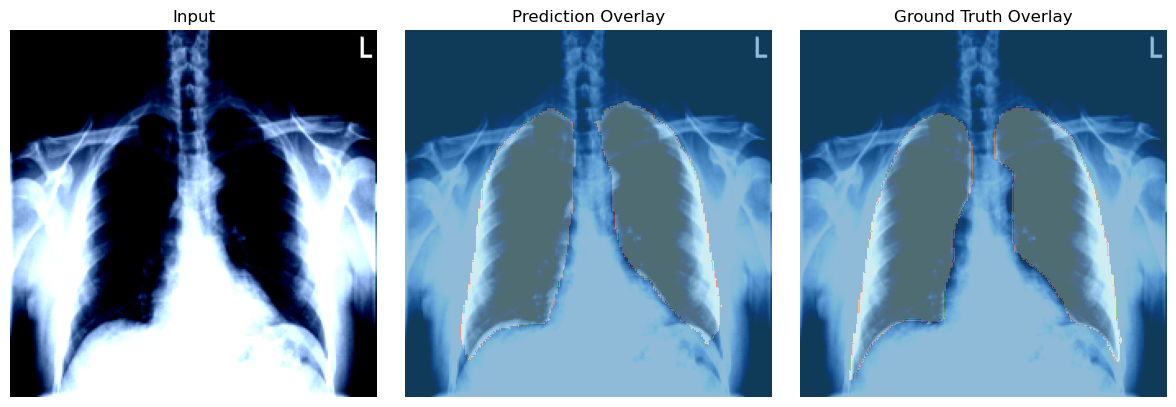


Classifier confidence: 96.43%


In [13]:
prediction, confidence, label = sample_and_predict(model, dataloaders['val'], device)

print( f'\nClassifier confidence: {confidence*100:4.2f}%' )